#SEResNet50

In [4]:
# installs
!pip install --upgrade monai # model
!pip install medmnist # data

In [6]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from medmnist import RetinaMNIST
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize
from monai.networks.blocks import MLPBlock
from torchvision import models, transforms
import torch.nn.functional as F

import monai
from monai.apps import download_and_extract
from monai.data import CacheDataset, DataLoader, pad_list_data_collate, partition_dataset
from monai.networks import eval_mode
import monai.transforms as mt
from monai.utils import set_determinism

from sklearn.metrics import confusion_matrix
import seaborn as sns

## Load Dataset

In [7]:
# load RetinaMNIST dataset
def get_retina_mnist_data(split, transform=None):
    return RetinaMNIST(split=split, transform=transform, download=True, as_rgb=True)

# preprocessing transformation for the RetinaMNIST images
transform = transforms.Compose([
    transforms.Resize(256),  # resize the image to at least 256 pixels in the smaller dimension
    transforms.CenterCrop(224),  # crop the center of the image to 224x224 pixels (required by ResNet)
    transforms.ToTensor(),  # convert the image to a PyTorch tensor (values scaled to [0, 1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize using ImageNet stats
])

# load train and validation splits
train_dataset = get_retina_mnist_data("train", transform)
val_dataset = get_retina_mnist_data("val", transform)

100%|██████████| 3.29M/3.29M [00:00<00:00, 3.90MB/s]

Using downloaded and verified file: /root/.medmnist/retinamnist.npz


## Dataloader

In [8]:
# define batch size
batch_size = 32
# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Define Model

In [10]:
# Define the Squeeze-and-Excitation (SE) Block
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Global Average Pooling
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1)
        y = y.view(b, c)

        # Fully connected layers with Sigmoid activation
        y = F.relu(self.fc1(y))
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)

        return x * y.expand_as(x)

# Define the SEResNet50 Architecture
class SEResNet50(nn.Module):
    def __init__(self, num_classes=5):
        super(SEResNet50, self).__init__()

        # Load ResNet50 model from torchvision
        self.resnet50 = models.resnet50(pretrained=True)

        # Add SE block to ResNet50
        self.se_layer = SELayer(2048, reduction=16)  # 2048 is the channel size of the last layer in ResNet50

        # Replace the final fully connected layer for classification (5 classes)
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet50.conv1(x)  # First convolution layer
        x = self.resnet50.bn1(x)    # Batch normalization
        x = self.resnet50.relu(x)   # ReLU activation
        x = self.resnet50.maxpool(x)  # Max pooling

        # Pass through the ResNet layers
        x = self.resnet50.layer1(x)
        x = self.resnet50.layer2(x)
        x = self.resnet50.layer3(x)
        x = self.resnet50.layer4(x)

        # Apply SE Block
        x = self.se_layer(x)

        # Global Average Pooling
        x = self.resnet50.avgpool(x)
        x = torch.flatten(x, 1)

        # Fully connected layer (classification)
        x = self.resnet50.fc(x)

        return x


# Initialize model
num_classes = 5  # Number of classes for RetinaMNIST
model = SEResNet50(num_classes=num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


In [11]:
# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SEResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [12]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

## Train

In [13]:
# Training loop
num_epochs = 200
train_acc = []
val_acc = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.squeeze().to(device)

        optimizer.zero_grad()  # Zero the gradients before each backward pass
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total  # Calculate accuracy
    train_acc.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.squeeze().to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_acc.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/200, Loss: 1.3539, Accuracy: 44.91%
Validation Accuracy: 45.00%
Epoch 2/200, Loss: 1.2298, Accuracy: 48.89%
Validation Accuracy: 48.33%
Epoch 3/200, Loss: 1.1670, Accuracy: 51.57%
Validation Accuracy: 54.17%
Epoch 4/200, Loss: 1.1796, Accuracy: 49.63%
Validation Accuracy: 51.67%
Epoch 5/200, Loss: 1.1750, Accuracy: 51.20%
Validation Accuracy: 55.83%
Epoch 6/200, Loss: 1.1613, Accuracy: 51.94%
Validation Accuracy: 58.33%
Epoch 7/200, Loss: 1.1452, Accuracy: 52.04%
Validation Accuracy: 47.50%
Epoch 8/200, Loss: 1.1315, Accuracy: 53.06%
Validation Accuracy: 55.83%
Epoch 9/200, Loss: 1.1480, Accuracy: 53.33%
Validation Accuracy: 46.67%
Epoch 10/200, Loss: 1.1302, Accuracy: 53.43%
Validation Accuracy: 48.33%
Epoch 11/200, Loss: 1.1092, Accuracy: 53.52%
Validation Accuracy: 55.00%
Epoch 12/200, Loss: 1.1342, Accuracy: 53.33%
Validation Accuracy: 50.00%
Epoch 13/200, Loss: 1.1255, Accuracy: 52.78%
Validation Accuracy: 55.00%
Epoch 14/200, Loss: 1.1342, Accuracy: 53.15%
Validation Accu

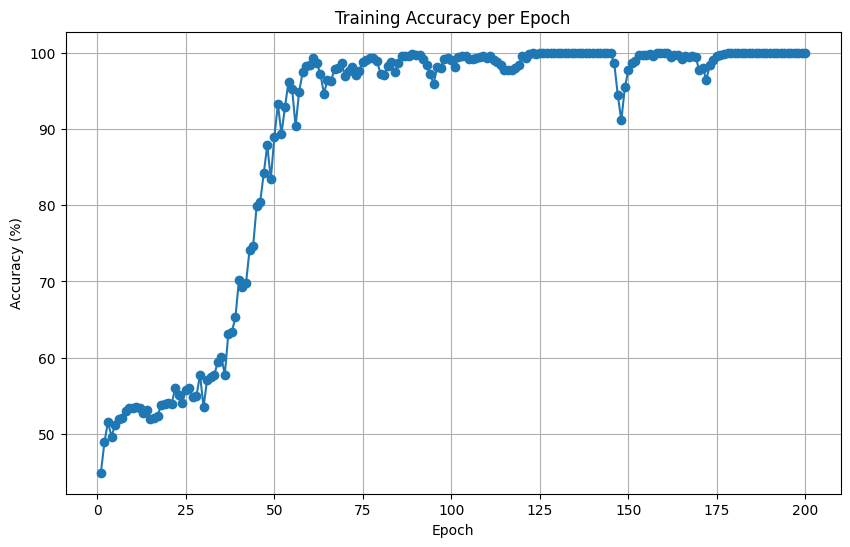

In [14]:
# Plot Training Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_acc, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy per Epoch")
plt.grid()
plt.show()

## Display Example Predictions

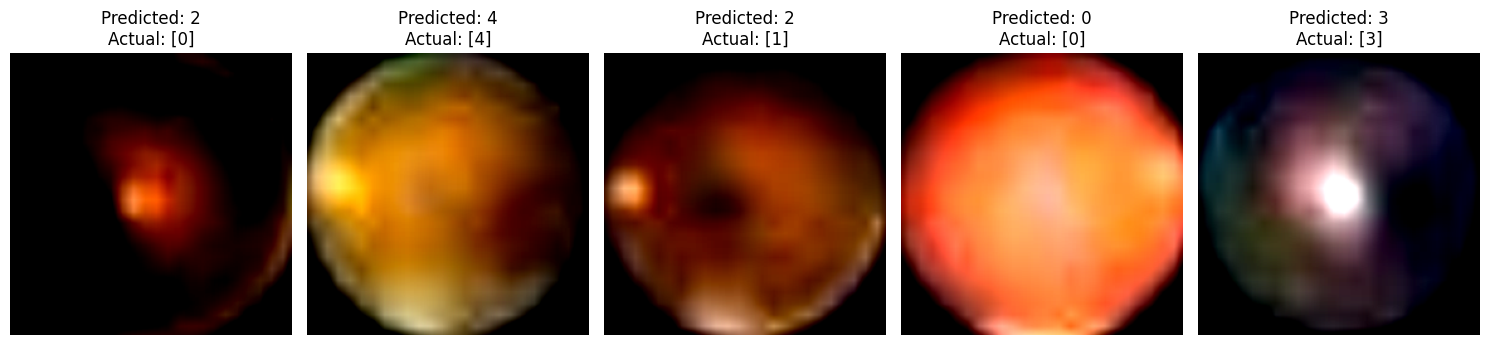

In [15]:
import random
import matplotlib.pyplot as plt

# Function to display random samples with predictions and actual labels
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    samples = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    # loop over each randomly selected sample index
    for i, idx in enumerate(samples):
        image, label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        with torch.no_grad():
            output = model(image_tensor)
            predicted_label = torch.argmax(output, 1).item()

        # move the image back to CPU for visualization
        image = image.permute(1, 2, 0).cpu().numpy()
        image = (image * 0.5) + 0.5  # undo normalization for visualization
        # plot the image on the corresponding axis
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Predicted: {predicted_label}\nActual: {label}")

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, val_dataset, num_samples=5)

## Confusion Matrix

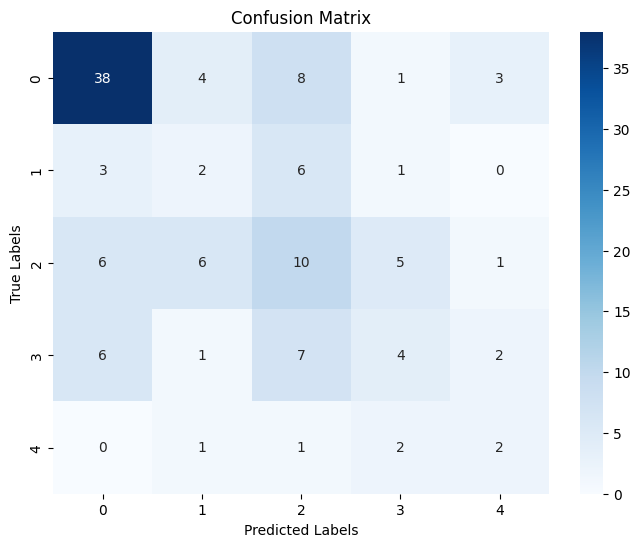

In [16]:
# plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# generate confusion matrix
def generate_confusion_matrix(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No need to track gradients during inference
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            all_labels.extend(labels.cpu().numpy())  # Store true labels
            all_preds.extend(predicted.cpu().numpy())  # Store predicted labels

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Define the class names (adjust if necessary based on your dataset)
    class_names = [str(i) for i in range(5)]  # Assuming 5 classes (0 to 4)

    # Plot confusion matrix
    plot_confusion_matrix(cm, class_names)

generate_confusion_matrix(model, val_loader)

## Saliency

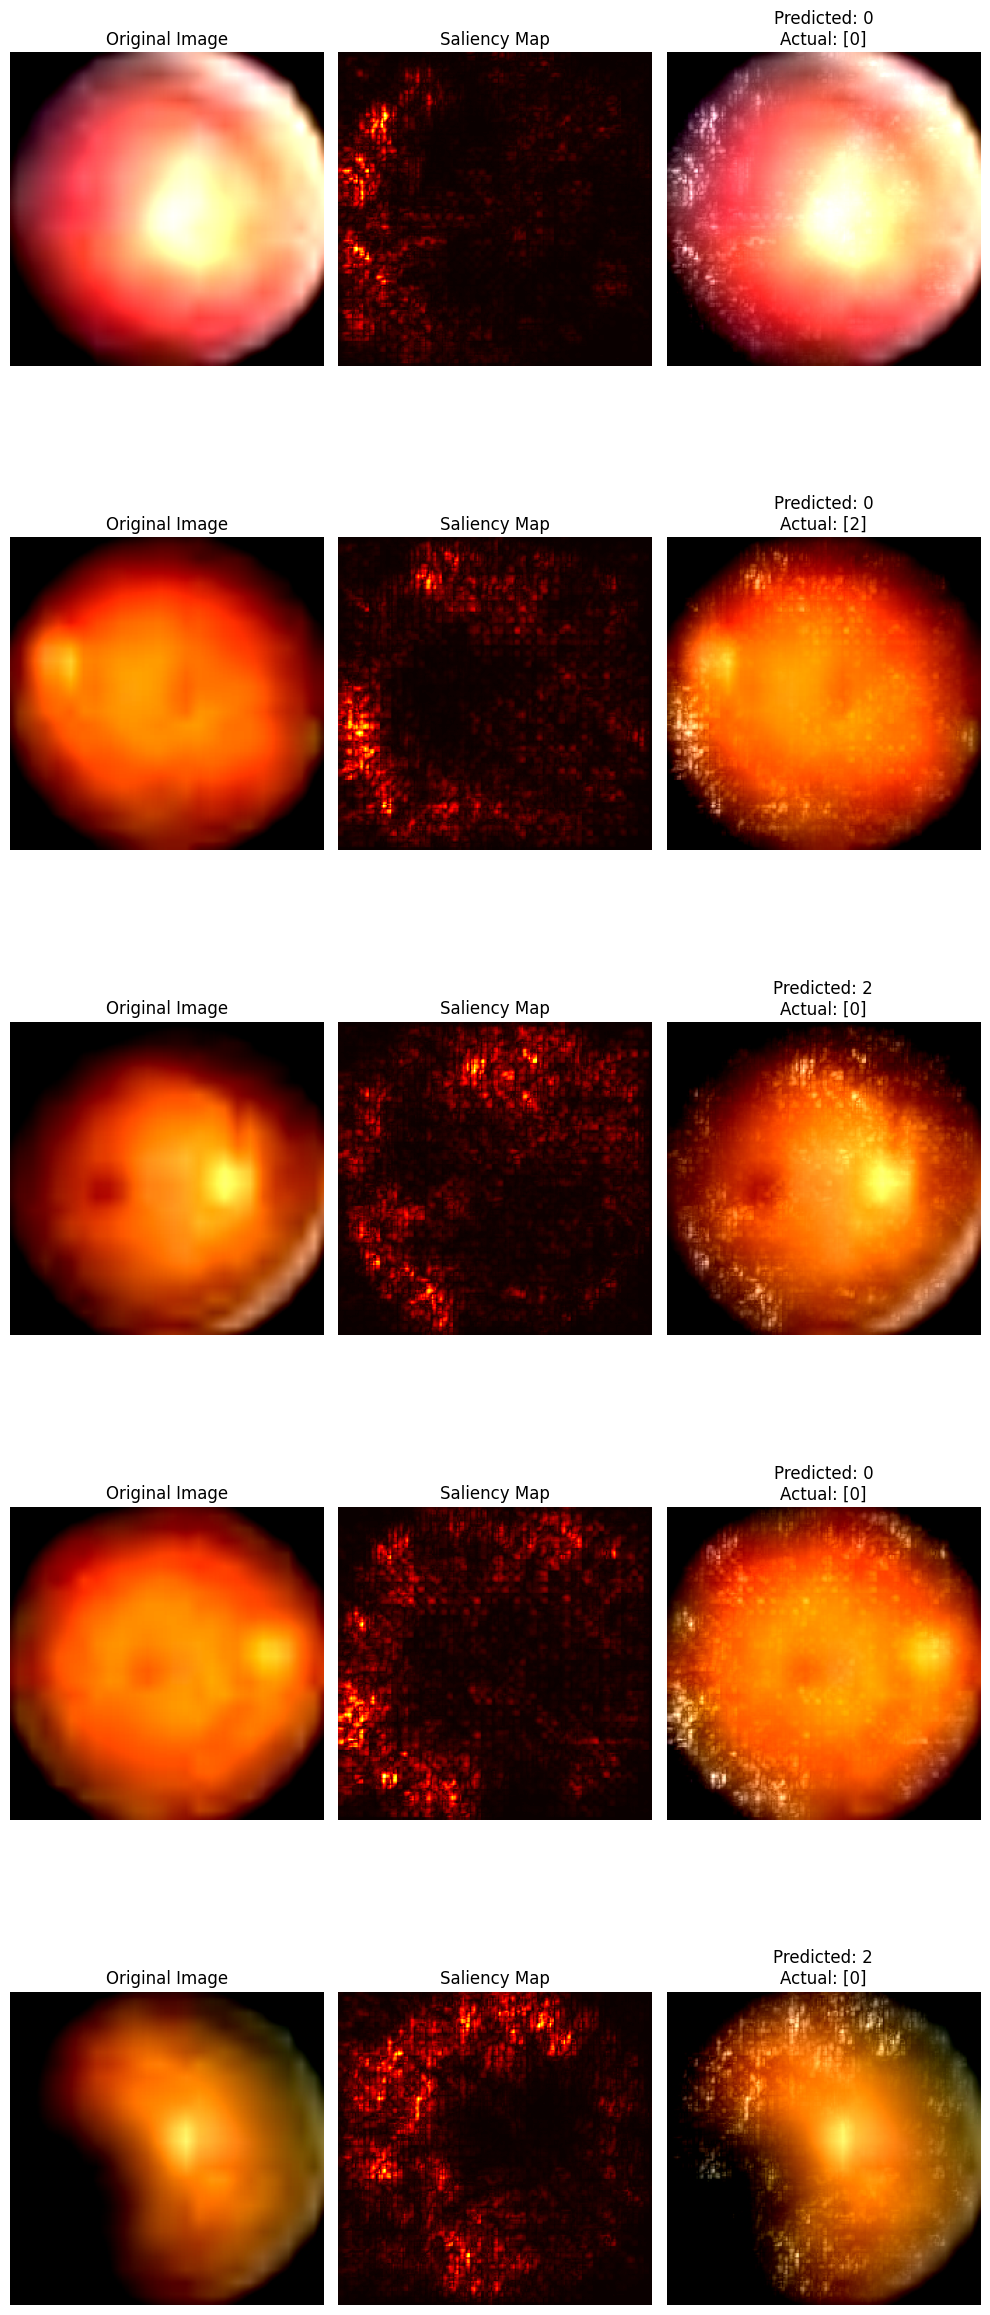

In [17]:
def visualize_saliency(model, dataset, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    samples = random.sample(range(len(dataset)), num_samples)  # Randomly sample from the dataset

    # Create a subplot grid (num_samples rows, 3 columns for original, saliency map, and overlay)
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))

    for i, idx in enumerate(samples):
        image, label = dataset[idx]  # Get the image and its label from the dataset
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to the device (GPU/CPU)

        image_tensor.requires_grad_()  # Enable gradient tracking for the image tensor

        # Forward pass to get model predictions
        output = model(image_tensor)  # Forward pass through the model
        predicted_label = torch.argmax(output, 1).item()  # Get the predicted class

        # Compute gradients of the output w.r.t the input image
        model.zero_grad()  # Reset gradients from the previous backward pass
        output[0, predicted_label].backward()  # Backpropagate to get the gradient for the predicted class
        saliency = image_tensor.grad.abs().squeeze().cpu().numpy()  # Get the saliency map (absolute gradient)

        # Normalize the saliency map (optional but useful for visualization)
        saliency = saliency.max(axis=0)  # Take the maximum saliency value across channels (for RGB)
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize to [0, 1]

        # Undo normalization for the original image (to bring it back to [0, 1] for display)
        image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert the image to numpy (H, W, C)
        image_np = (image_np * 0.5) + 0.5  # Undo the normalization (from [-1, 1] back to [0, 1])

        # Overlay saliency map on top of the original image
        overlay = np.clip(image_np + np.expand_dims(saliency, axis=-1), 0, 1)  # Combine saliency with the image

        # Plot the original image, the saliency map, and the overlay
        axes[i, 0].imshow(image_np)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Original Image")

        axes[i, 1].imshow(saliency, cmap="hot")  # Display the saliency map with a 'hot' colormap
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Saliency Map")

        axes[i, 2].imshow(overlay)  # Display the image with the saliency map overlaid
        axes[i, 2].axis("off")
        axes[i, 2].set_title(f"Predicted: {predicted_label}\nActual: {label}")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Call the function to visualize saliency maps on the validation dataset
visualize_saliency(model, val_dataset, num_samples=5)